In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

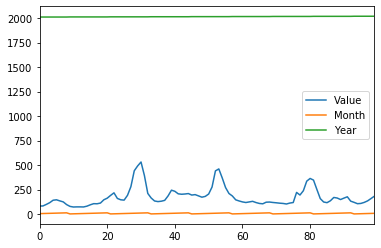

In [3]:
series=pd.read_csv('onionwpi.csv')
series['Month'] = [int(k[4:6]) for k in series['Date'].values]
series['Year'] = [int(k[6:10]) for k in series['Date'].values]
series['Date'] = [k[4:10] for k in series['Date'].values]
#series.head()
sr=series[:100]
sr.plot()
plt.show()

## Univariate Methods

In [4]:
series.count()

Date     104
Value    104
Month    104
Year     104
dtype: int64

### Train/Test split

In [5]:
train = series['Value'].values[:75]
test = series['Value'].values[75:]

### Partitioning

In [6]:
from itertools import product

levels = ['VL','L','NL', 'NH', 'H', 'VH']
sublevels = [str(k) for k in np.arange(0,2)]
names = []
for combination in product(*[levels, sublevels]):
  names.append(combination[0]+combination[1])  
print(names)

['VL0', 'VL1', 'L0', 'L1', 'NL0', 'NL1', 'NH0', 'NH1', 'H0', 'H1', 'VH0', 'VH1']


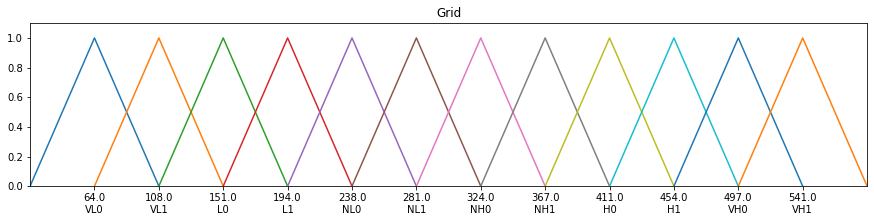

In [7]:
from pyFTS.partitioners import Grid 

part = Grid.GridPartitioner(data=train,npart=12,names=names)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
part.plot(ax)

### HOFTS

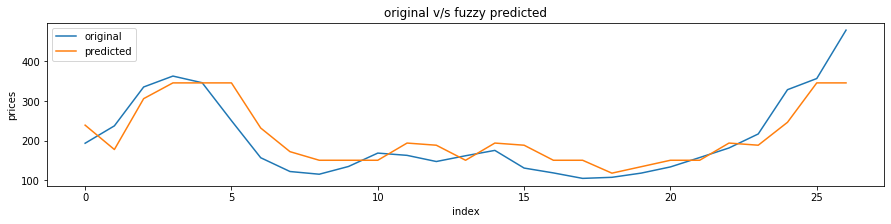

,RMSE,MAPE,U
0,47.7,19.82,0.81


In [8]:
from pyFTS.models import hofts 
from pyFTS.benchmarks import Measures

# hofts
mesr = []
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
ax.plot(test[2:],label='original')
model = hofts.HighOrderFTS(order=2, partitioner=part)
model.fit(train)
forecasts = model.predict(test)

ax.plot(forecasts,label='predicted')
plt.xlabel('index')
plt.ylabel('prices')
plt.title('original v/s fuzzy predicted')
plt.legend()
plt.show()

rmse, mape, u = Measures.get_point_statistics(test, model)
mesr.append([rmse, mape, u])

pd.DataFrame(mesr, columns=['RMSE','MAPE','U'])

### WHOFTS

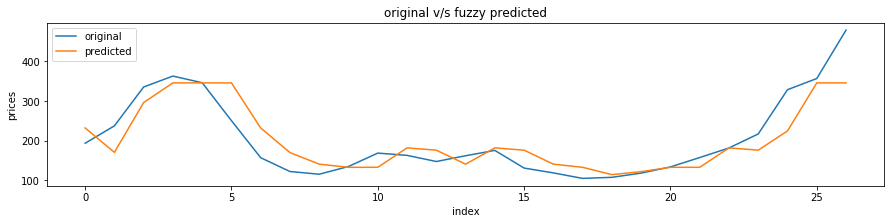

,RMSE,MAPE,U
0,48.1,17.31,0.82


In [9]:
# weighted-hofts
mesr = []
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
ax.plot(test[2:],label='original')
model = hofts.WeightedHighOrderFTS(order=2, partitioner=part)
model.fit(train)
forecasts = model.predict(test)
ax.plot(forecasts,label='predicted')
plt.xlabel('index')
plt.ylabel('prices')
plt.title('original v/s fuzzy predicted')
plt.legend()
plt.show()
rmse, mape, u = Measures.get_point_statistics(test, model)
mesr.append([rmse, mape, u])
pd.DataFrame(mesr, columns=['RMSE','MAPE','U'])

### PWFTS

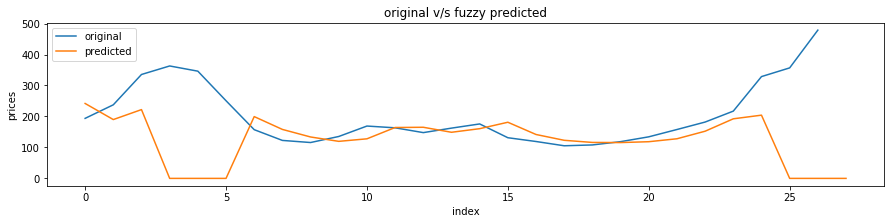

,RMSE,MAPE,U
0,162.84,33.16,2.7


In [11]:
from pyFTS.models import pwfts

# pwfts
mesr = []
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
ax.plot(test[2:],label='original')
model = pwfts.ProbabilisticWeightedFTS(order=2, partitioner=part)
model.fit(train)
forecasts = model.predict(test)
ax.plot(forecasts,label='predicted')
plt.xlabel('index')
plt.ylabel('prices')
plt.title('original v/s fuzzy predicted')
plt.legend()
plt.show()
rmse, mape, u = Measures.get_point_statistics(test, model)
mesr.append([rmse, mape, u])
pd.DataFrame(mesr, columns=['RMSE','MAPE','U'])

## Multivariate Methods

### Variables and Partitioning

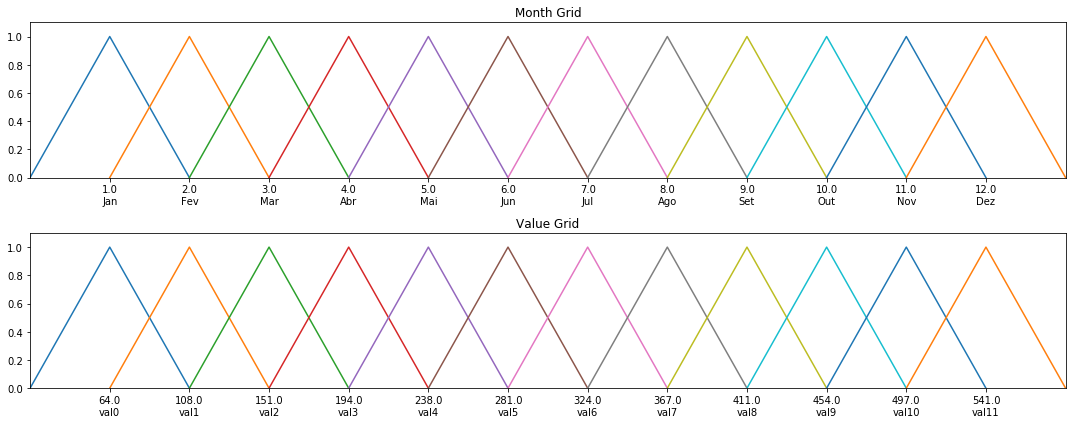

In [12]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime


mv_train = series.iloc[:75]
mv_test = series.iloc[75:]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,6])


sp = {'names': ['Jan','Fev','Mar','Abr','Mai','Jun','Jul', 'Ago','Set','Out','Nov','Dez']}

vmonth = variable.Variable("Month", data_label="Month", partitioner=Grid.GridPartitioner, npart=12, 
                           data=mv_train, partitioner_specific=sp)

vmonth.partitioner.plot(ax[0])

vvalue = variable.Variable("Value", data_label="Value", alias='val',
                         partitioner=Grid.GridPartitioner, npart=12,  
                         data=mv_train) 

vvalue.partitioner.plot(ax[1])

plt.tight_layout()

### MVFTS, WMVFTS and FIG-FTS

In [14]:
len(mv_test)

29

,Model,RMSE,U
0,Multivariate FTS,59.78,0.96
1,Weighted Multivariate FTS,58.33,0.92
2,Granular Weighted Multivariate FTS,49.69,0.90


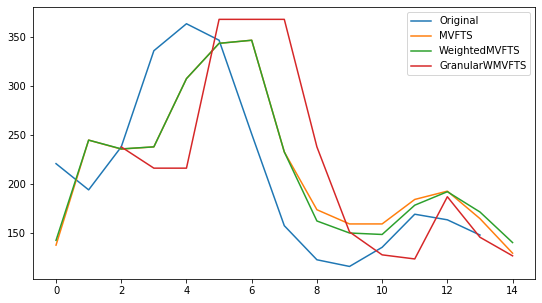

In [22]:
from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, granular

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9,5])

ax.plot(mv_test['Value'].values[1:15],label='Original')

model1 = mvfts.MVFTS(explanatory_variables=[vmonth, vvalue], target_variable=vvalue)
model2 = wmvfts.WeightedMVFTS(explanatory_variables=[vmonth, vvalue], target_variable=vvalue)
model3 = granular.GranularWMVFTS(explanatory_variables=[vmonth, vvalue], target_variable=vvalue, 
                                 order=2, knn=2)

rows = []

for ct, model in enumerate([model1, model2, model3]):
  
  model.fit(mv_train)
  
  forecasts = model.predict(mv_test.iloc[:100])
  if model.is_high_order:
    for k in range(model.order):
      forecasts.insert(0,None)
  ax.plot(forecasts[:15], label=model.shortname)
  rmse, mape, u = Measures.get_point_statistics(mv_test, model)
  
  rows.append([model.name, rmse, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=1, bbox_to_anchor=(1, 1))
pd.DataFrame(rows, columns=['Model','RMSE','U'])
